🔍 LA-GAS: Language Agent General Assessment Suite 란
- OpenAI에서 공개한 평가 툴킷 중 하나로, LLM 기반 에이전트의 행동을 평가하기 위해 만들어졌습니다.
- "에이전트 평가"라는 맥락에서 개발되었으며, 단순한 QA 능력 이상으로 지시 따르기, 추론, 플래닝, 툴 사용 등 복합적 행동 수행 능력을 측정할 수 있도록 설계되어 있습니다.

**RAGAS 평가 지표**
- "답이 문서 기반으로 정확한가?" → faithfulness
- "질문이 좋은가?" → answer_relevancy
- "검색 문서가 적절한가?" → context_precision, context_recall
- "정답이랑 얼마나 같은가?" → answer_correctness

In [ ]:
# !pip install ragas
# !pip install pymupdf
# !pip install pypdf

In [1]:
# 1. 라이브러리 가져오기
# from langchain_community.document_loaders import PyPDFLoader  # (비활성화된 코드)
from langchain_community.document_loaders import (
    PyMuPDFLoader,
)  # PDF 문서 로드용 (한글 PDF에 더 적합)
from langchain.text_splitter import RecursiveCharacterTextSplitter  # 텍스트 분할기
from langchain_openai import OpenAIEmbeddings  # 임베딩 모델
from langchain_community.embeddings import HuggingFaceEmbeddings  # 임베딩 모델
from langchain_community.vectorstores import FAISS  # 벡터스토어 (FAISS)
from langchain.chains import RetrievalQA  # RAG QA 체인
from langchain_openai import ChatOpenAI  # OpenAI LLM 연동

# 1-7. RAGAS 평가 지표
from ragas.metrics import (
    faithfulness,  # 답이 문서 기반으로 정확한가?
    answer_relevancy,  # 생성된 답변이 질문에 얼마나 적절한가?
    context_precision,  # 컨텍스트 정보가 관련성 높은가?
    context_recall,  # 필요한 정보가 모두 포함되었는가?
    answer_correctness,  # 참조 정답과 얼마나 유사한가? (참조 답변 필요)
)
from ragas.evaluation import evaluate  # RAGAS 평가 함수
from datasets import Dataset  # 평가용 데이터셋 구조
import pandas as pd  # 평가 결과 DataFrame 처리용
from tqdm import tqdm

/opt/anaconda3/envs/llm_env/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/opt/anaconda3/envs/llm_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 2. API 키 로딩
import os
from dotenv import load_dotenv

load_dotenv()  # .env 파일에서 환경변수 로딩
api_key = os.getenv("OPENAI_API_KEY")  # OpenAI 키 불러오기

In [3]:
# 3. 문서 로드 함수 정의
def load_documents(pdf_path):
    # loader = PyPDFLoader(pdf_path)  # 주어진 경로의 PDF 파일을 PyPDFLoader로 불러옴
    loader = PyMuPDFLoader(pdf_path)  # 한국어인 경우 OCR 없이도 더 잘 작동
    documents = loader.load()  # PDF 내용을 로드하여 documents 리스트로 저장
    return documents  # 로드된 documents 반환

In [4]:
# 4. 문서 분할 함수 정의
def split_documents(documents):
    # 문서를 작은 텍스트 조각으로 나누기 위한 텍스트 분할기 생성
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,  # 한 조각의 최대 길이를 1000자로 설정
        chunk_overlap=200,  # 조각 간에 200자의 중첩을 포함시킴
    )

    # 주어진 문서들을 분할하여 리스트로 반환
    splits = text_splitter.split_documents(documents)
    return splits  # 분할된 문서 리스트 반환

- FAISS는 Facebook이 만든 빠른 유사도 검색 라이브러리로, 대규모 벡터를 빠르게 검색할 수 있도록 인덱싱

In [5]:
# 5. 벡터스토어 생성 함수
def create_vectorstore(splits):
    # 텍스트 조각들을 임베딩하기 위한 OpenAI 임베딩 모델 로드
    embeddings = OpenAIEmbeddings()

    # # 모델 이름 설정 (예: `all-MiniLM-L6-v2`)
    # model_name = "sentence-transformers/all-MiniLM-L6-v2"
    # # 임베딩 객체 생성
    # embeddings = HuggingFaceEmbeddings(model_name=model_name)

    # FAISS 벡터스토어에 문서와 임베딩을 기반으로 인덱싱 (검색 가능한 벡터 DB 생성)
    vectorstore = FAISS.from_documents(splits, embeddings)

    return vectorstore  # 생성된 벡터스토어 객체 반환

In [6]:
# 6. RAG QA 파이프라인 생성 함수
def create_rag_pipeline(vectorstore):
    # 환경 변수에서 모델 이름을 불러와 OpenAI LLM 초기화 (온도=0: 일관된 응답 생성)
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

    # FAISS 벡터스토어를 검색기(retriever)로 변환 (유사한 문서 상위 3개 검색)
    retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

    # RAG(Retrieval-Augmented Generation) QA 체인 구성
    qa_chain = RetrievalQA.from_chain_type(
        llm=llm,  # 사용할 언어 모델
        chain_type="stuff",  # 문서를 하나로 합쳐서 LLM에 넣는 방식
        retriever=retriever,  # 문서 검색기
        return_source_documents=True,  # 응답 시 원본 문서도 함께 반환
    )

    return qa_chain  # 완성된 RAG QA 체인 반환

In [7]:
# 7. 테스트용 질문 생성 함수
def generate_test_questions(pdf_path, num_questions=5):
    documents = load_documents(pdf_path)
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.9)
    questions = []

    for i in range(num_questions):
        prompt = f"""
다음 문서를 바탕으로 질문을 1개 생성해 주세요.
반드시 질문 문장만 출력해 주세요. '질문:'이라는 표현 없이 완전한 한국어 질문 형태로만 작성해 주세요.

문서 내용:
{documents[i % len(documents)].page_content}
"""
        question = llm.invoke(prompt).content
        questions.append(question)

    return questions  # 생성된 질문 리스트 반환

In [8]:
# 8. RAGAS 평가 수행 함수
def evaluate_with_ragas(qa_chain, questions):
    # 8-1. 사용할 메트릭 설정
    use_faithfulness = True
    use_answer_relevancy = True
    use_context_precision = True
    use_context_recall = True
    use_answer_correctness = False  # 정답 필요하므로 비활성화

    # 8-2. 평가용 데이터 초기화
    evaluation_data = {"question": [], "answer": [], "contexts": []}
    if use_context_precision or use_context_recall:
        evaluation_data["reference"] = []

    # 8-3. 각 질문에 대해 RAG 수행 및 데이터 수집
    for question in questions:
        result = qa_chain.invoke(question)
        answer = result["result"]
        contexts = [doc.page_content for doc in result["source_documents"]]

        evaluation_data["question"].append(question)
        evaluation_data["answer"].append(answer)
        evaluation_data["contexts"].append(contexts)

        if use_context_precision or use_context_recall:
            evaluation_data["reference"].append(contexts[0] if contexts else "")

    # 8-4. 평가용 Dataset 생성
    eval_dataset = Dataset.from_dict(evaluation_data)

    # 8-5. 활성화된 메트릭 추가
    metrics = []
    if use_faithfulness:
        metrics.append(faithfulness)
    if use_answer_relevancy:
        metrics.append(answer_relevancy)
    if use_context_precision:
        metrics.append(context_precision)
    if use_context_recall:
        metrics.append(context_recall)
    if use_answer_correctness:
        metrics.append(answer_correctness)

    # 8-6. 평가 실행
    results = evaluate(eval_dataset, metrics=metrics)

    # 8-7. 결과를 DataFrame으로 변환
    results_df = pd.DataFrame(
        {"question": evaluation_data["question"], "answer": evaluation_data["answer"]}
    )
    for metric in metrics:
        results_df[metric.name] = results[metric.name]

    return results_df

In [ ]:
# 9. 실행
from pathlib import Path

# 9-1. 평가할 PDF 경로 지정
pdf_path = Path(__file__).parent / "data" / "소나기.pdf"
# 9-2. 문서 로드
documents = load_documents(pdf_path)
# 9-3. 문서 분할
splits = split_documents(documents)
# 9-4. 벡터스토어 생성
vectorstore = create_vectorstore(splits)
# 9-5. RAG 파이프라인 구성
qa_chain = create_rag_pipeline(vectorstore)

# 9-6. 질문 10개 생성
questions = generate_test_questions(pdf_path, 10)

# 9-7. 평가 실행
results = evaluate_with_ragas(qa_chain, questions)

ValueError: File path ./data/소나기.pdf is not a valid file or url

In [ ]:
# 9-8. 결과 출력
print("평가 결과:")
print(results)

평가 결과:
                                  question  \
0          소년은 소녀와의 만남 이후 어떤 감정을 느끼게 되었나요?   
1     소년은 소녀와 함께 저 산 너머에 가보려고 하는 마음이 있었나요?   
2               소녀는 왜 마타리꽃을 양산 받듯이 해 보였을까?   
3  소년이 소녀를 위해 어떻게 행동했는지 구체적으로 설명해 줄 수 있나요?   
4  소녀는 왜 그 날 소나기 맞은 이후로 얼굴이 해쓱해졌다고 생각했을까요?   
5        소년은 소녀에게 이사 가기 전에 어떤 말을 해주고 싶었나요?   
6                   가면 소녀는 어떤 의미를 지니고 있을까?   
7          소년은 소녀와의 만남 이후 어떤 감정을 느끼게 되었나요?   
8      소년은 왜 소녀와 함께 저 산 너머를 가보려고 하지 않았을까요?   
9   소녀와 소년이 꽃을 꺾는 상황에서 어떤 꽃이 가장 예쁘다고 느꼈는가?   

                                              answer  faithfulness  \
0  소년은 소녀와의 만남 이후 허전함과 그리움을 느끼게 되었습니다. 소녀의 그림자가 보...      1.000000   
1  주어진 텍스트에서는 소년이 소녀와 함께 저 산 너머에 가보려고 하는 마음에 대한 언...      1.000000   
2  소녀가 마타리꽃을 양산 받듯이 해 보인 이유는 꽃의 모양이 양산과 비슷하게 생겼기 ...      0.000000   
3  소년은 소녀를 위해 여러 가지 행동을 했습니다. 처음에 소녀가 개울가에서 물장난을 ...      0.777778   
4  주어진 텍스트에서는 소녀가 소나기를 맞은 이후로 얼굴이 해쓱해졌다는 언급이 없습니다...      1.000000   
5  소년은 소녀에게 병이 좀 나아지면 이사 가기 전에 한 번 개울가로 나와 달라는 말을...      1.000000

In [ ]:
# 10. 평균 점수 출력
metric_columns = [
    col for col in results.columns if col not in ["question", "answer"]
]  # 10-1. 메트릭 열 추출
if metric_columns:
    avg_scores = results[metric_columns].mean()  # 10-2. 평균 계산
    print("\n평균 점수:")
    print(avg_scores)


평균 점수:
faithfulness         0.844444
answer_relevancy     0.431219
context_precision    0.683333
context_recall       1.000000
dtype: float64


### 결과 시각화

In [19]:
#!pip install seaborn
!pip install koreanize-matplotlib

  Using cached koreanize_matplotlib-0.1.1-py3-none-any.whl.metadata (992 bytes)
Using cached koreanize_matplotlib-0.1.1-py3-none-any.whl (7.9 MB)


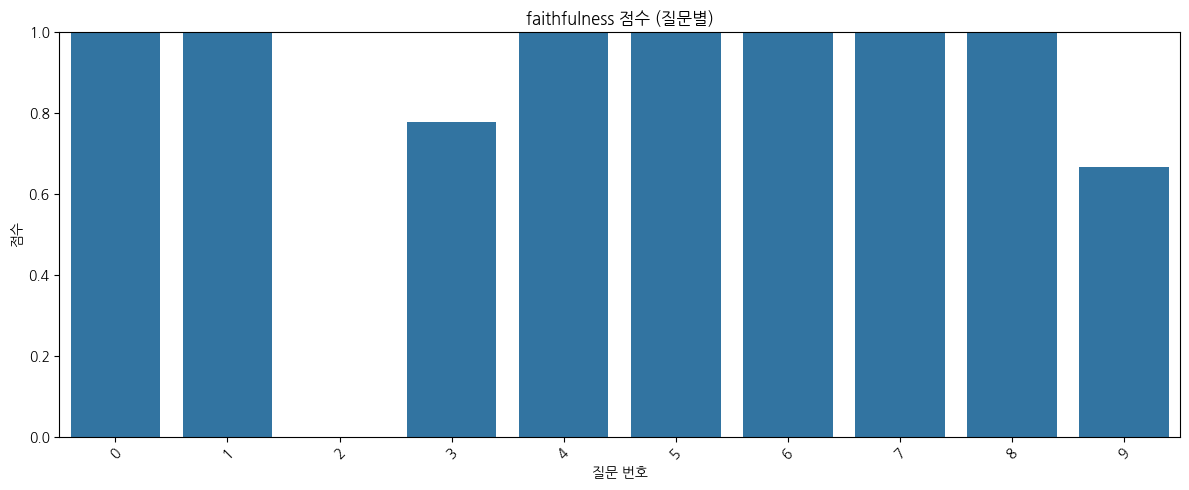

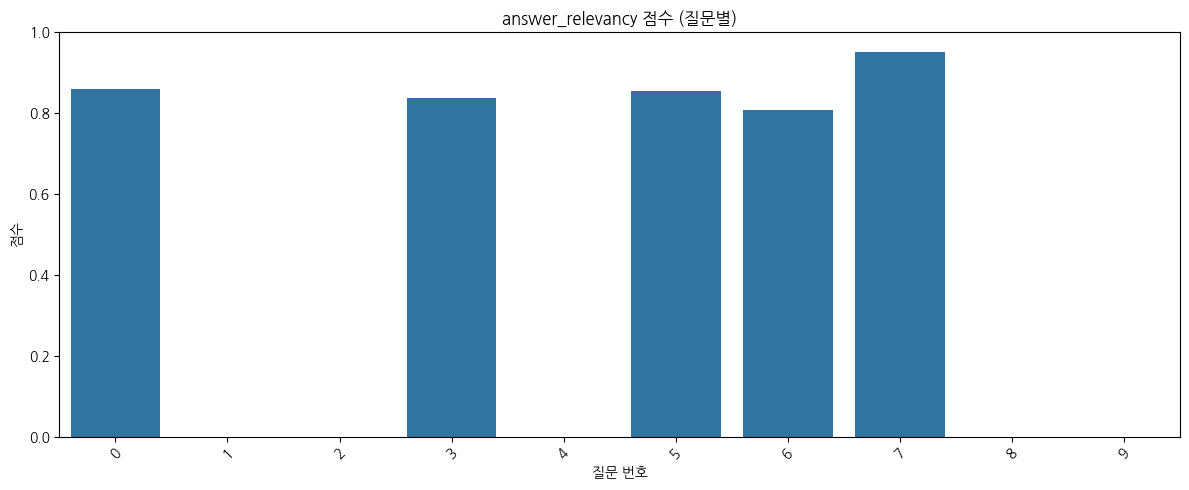

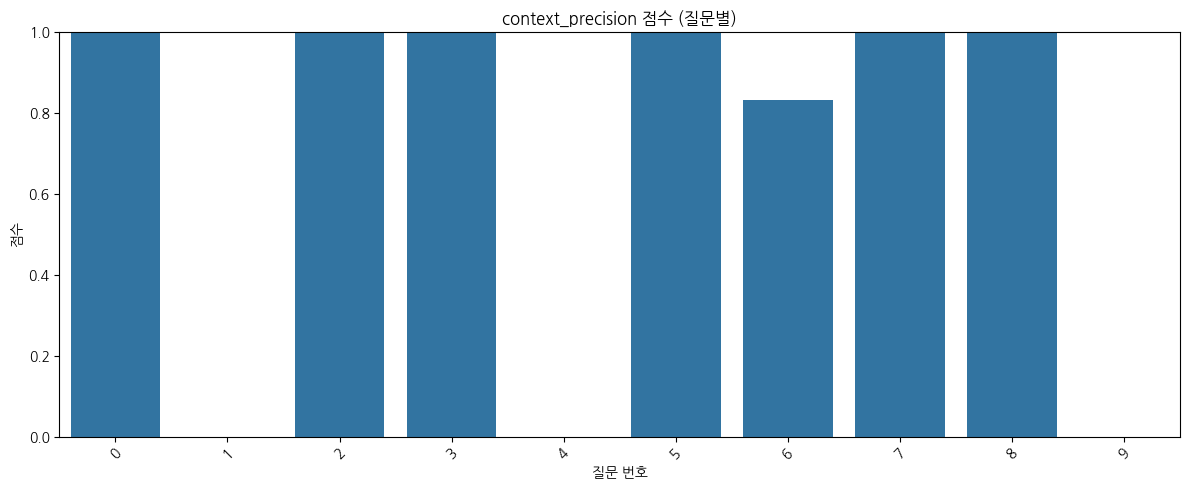

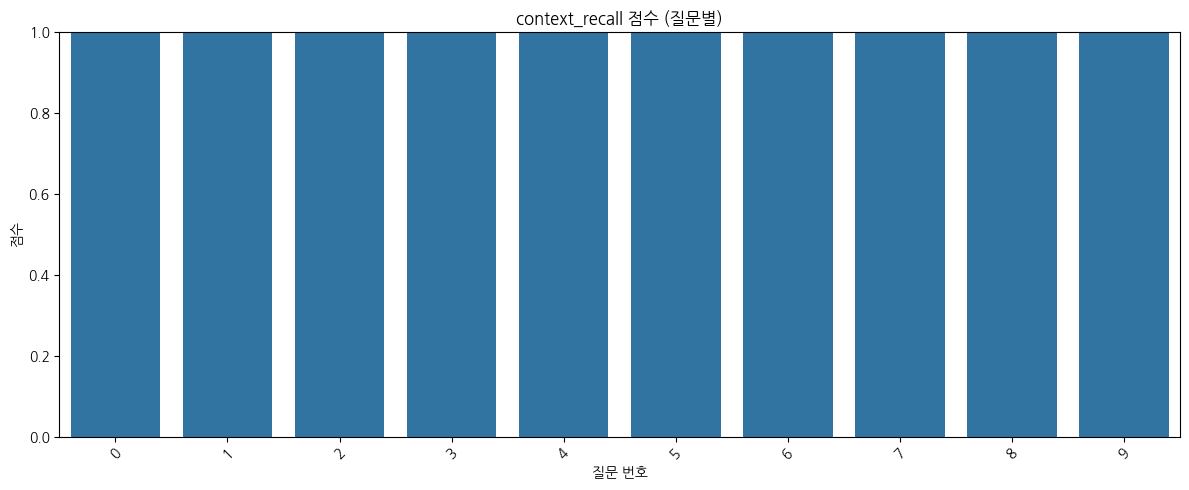

In [ ]:
# 질문별 지표 점수 막대그래프
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns


def visualize_ragas_results(results_df):
    metric_columns = [
        col for col in results_df.columns if col not in ["question", "answer"]
    ]

    for metric in metric_columns:
        plt.figure(figsize=(12, 5))
        sns.barplot(x=results_df.index, y=results_df[metric])
        plt.title(f"{metric} 점수 (질문별)")
        plt.xlabel("질문 번호")
        plt.ylabel("점수")
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


visualize_ragas_results(results)

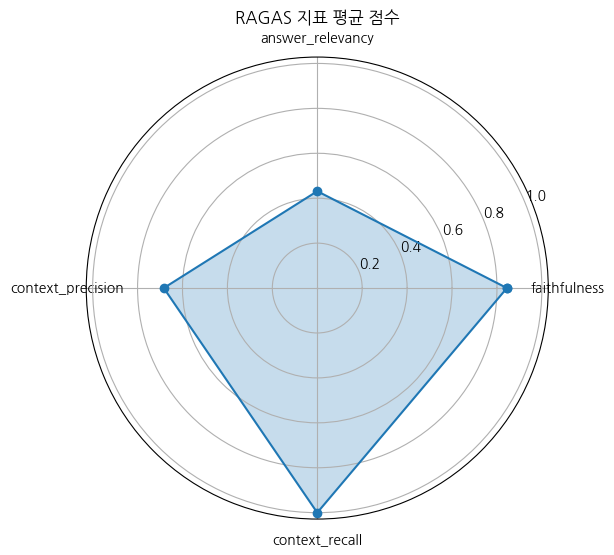

In [ ]:
# 전체 평균값 레이다 차트
import numpy as np
import matplotlib.pyplot as plt


def plot_radar_chart(avg_scores):
    metrics = avg_scores.index.tolist()
    scores = avg_scores.values.tolist()

    # 각 축의 각도 설정 (점수를 먼저 안 늘림)
    num_metrics = len(metrics)
    angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()

    # 시작점으로 되돌아오기 위해 첫 점 추가 (마지막 값 = 첫 값)
    scores += scores[:1]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, scores, marker="o")
    ax.fill(angles, scores, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_title("RAGAS 지표 평균 점수")
    plt.show()


plot_radar_chart(avg_scores)

### Custom Metric

In [ ]:
# 사용자 정의 평가 지표로 'hallucinations_metric'을 생성함
# Faithfulness 점수를 기반으로 환각 정도를 계산 (1 - faithfulness)

from dataclasses import dataclass, field  # 데이터 클래스 사용을 위한 모듈
from ragas.metrics.base import (
    MetricWithLLM,
    SingleTurnMetric,
    MetricType,
)  # 평가 지표의 기본 클래스들
from ragas.metrics import Faithfulness  # 기존의 Faithfulness 메트릭 사용
import typing as t  # 타입 힌트를 위한 모듈
from ragas.callbacks import Callbacks  # 평가 진행 중 이벤트 콜백
from ragas.dataset_schema import SingleTurnSample  # 단일 질문-응답 샘플 형식 정의


# 데이터 클래스 선언: 사용자 정의 평가 지표 HallucinationsMetric 정의
@dataclass
class HallucinationsMetric(MetricWithLLM, SingleTurnMetric):
    # 지표 이름 설정
    name: str = "hallucinations_metric"

    # 이 지표를 계산하기 위해 필요한 데이터 열 정의 (사용자 질문, 응답, 검색된 문맥)
    _required_columns: t.Dict[MetricType, t.Set[str]] = field(
        default_factory=lambda: {
            MetricType.SINGLE_TURN: {"user_input", "response", "retrieved_contexts"}
        }
    )

    # 클래스 초기화 이후 실행되는 후처리 함수
    def __post_init__(self):
        # 내부적으로 Faithfulness 메트릭을 초기화하여 활용함
        self.faithfulness_metric = Faithfulness(llm=self.llm)

    # 실제 점수를 계산하는 비동기 함수
    async def _single_turn_ascore(
        self, sample: SingleTurnSample, callbacks: Callbacks
    ) -> float:
        # Faithfulness 점수를 먼저 계산함
        faithfulness_score = await self.faithfulness_metric.single_turn_ascore(
            sample, callbacks
        )
        # 환각 점수 = 1 - faithfulness 점수
        return 1 - faithfulness_score

In [ ]:
import os  # 환경변수에서 API 키나 모델명 등을 불러오기 위해 사용

from ragas.llms import (
    LangchainLLMWrapper,
)  # LangChain의 LLM을 RAGAS에서 사용 가능하도록 감싸주는 래퍼

# OpenAI의 챗 모델을 LangChain에서 불러오기
llm = ChatOpenAI(
    temperature=0,  # 일관된 결과를 위해 생성 다양성 최소화
    model_name="gpt-4o-mini",  # 환경변수에서 모델 이름 불러오기 (예: "gpt-4")
)

# RAGAS에서 사용할 수 있도록 LangChain LLM을 래핑
evaluator_llm = LangchainLLMWrapper(llm)

# 앞서 정의한 환각 평가 메트릭에 LLM을 연결하여 인스턴스 생성
hallucinations_metric = HallucinationsMetric(llm=evaluator_llm)

In [ ]:
# 단일 질문-응답 샘플을 생성하여 환각 점수를 계산하는 예시
sample = SingleTurnSample(
    user_input="파리는 어느 나라의 수도인가요?",
    response="파리는 프랑스의 수도입니다.",
    retrieved_contexts=[
        "파리는 프랑스의 수도입니다. 프랑스는 유럽에 위치한 국가로, 파리는 세계적인 문화, 예술, 패션의 중심지로 알려져 있습니다."
    ],
)
# 비동기 함수 실행 및 결과 출력
score = await hallucinations_metric.single_turn_ascore(sample)
print("Hallucination 점수:", score)

Hallucination 점수: 0.0


In [ ]:
# 단일 질문-응답 샘플을 생성하여 환각 점수를 계산하는 예시
sample = SingleTurnSample(
    user_input="파리는 어느 나라의 수도인가요?",
    response="파리는 프랑스의 수도입니다.",
    retrieved_contexts=[
        "파리는 독일의 수도입니다. 독일은 유럽에 위치한 국가로, 파리는 세계적인 문화, 예술, 패션의 중심지로 알려져 있습니다."
    ],
)
await hallucinations_metric.single_turn_ascore(sample)

# 비동기 함수 실행 및 결과 출력
score = await hallucinations_metric.single_turn_ascore(sample)
print("Hallucination 점수:", score)

Hallucination 점수: 1.0


In [ ]:
from datasets import Dataset
import pandas as pd
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_precision,
    context_recall,
    answer_correctness,
)


# RAG 시스템(qa_chain)으로 생성된 답변과 그에 대한 질문·문맥 정보를 기반으로 RAGAS 평가 지표들(기본 + 사용자 정의 hallucinations)을 적용해 질문별 평가 결과를 데이터프레임 형태로 반환합니다.
def evaluate_with_ragas_with_custom_metric(qa_chain, questions):
    # 사용할 평가 지표 선택 (True: 사용 / False: 미사용)
    use_faithfulness = True
    use_answer_relevancy = True
    use_context_precision = True
    use_context_recall = True
    use_answer_correctness = False
    use_hallucinations = True  # 사용자 정의 환각 평가 추가 여부

    # 평가용 데이터 구조 초기화
    evaluation_data = {
        "question": [],  # 질문
        "answer": [],  # 생성된 답변
        "contexts": [],  # 검색된 문서 조각 (복수)
    }

    # context_precision / recall을 위한 reference 컬럼 추가
    if use_context_precision or use_context_recall:
        evaluation_data["reference"] = []

    # 각 질문에 대해 RAG QA 체인 실행
    for question in questions:
        result = qa_chain.invoke(question)  # RAG 시스템에서 답변 생성
        answer = result["result"]
        contexts = [doc.page_content for doc in result["source_documents"]]

        # 평가용 데이터 누적
        evaluation_data["question"].append(question)
        evaluation_data["answer"].append(answer)
        evaluation_data["contexts"].append(contexts)

        # reference 문서 (보통 첫 번째 context) 추가
        if use_context_precision or use_context_recall:
            evaluation_data["reference"].append(contexts[0] if contexts else "")

    # 평가를 위한 huggingface Dataset 객체 생성
    eval_dataset = Dataset.from_dict(evaluation_data)

    # 사용할 메트릭 리스트 구성
    metrics = []
    if use_faithfulness:
        metrics.append(faithfulness)
    if use_answer_relevancy:
        metrics.append(answer_relevancy)
    if use_context_precision:
        metrics.append(context_precision)
    if use_context_recall:
        metrics.append(context_recall)
    if use_answer_correctness:
        metrics.append(answer_correctness)
    if use_hallucinations:
        # 사용자 정의 환각 평가 메트릭 추가
        hallucinations_metric = HallucinationsMetric(llm=evaluator_llm)
        metrics.append(hallucinations_metric)

    # RAGAS 평가 실행
    results = evaluate(eval_dataset, metrics=metrics)

    # 결과를 DataFrame 형태로 정리
    results_df = pd.DataFrame(
        {"question": evaluation_data["question"], "answer": evaluation_data["answer"]}
    )

    # 각 메트릭 결과 컬럼에 추가
    for metric in metrics:
        results_df[metric.name] = results[metric.name]

    return results_df  # 평가 결과 데이터프레임 반환

In [34]:
results = evaluate_with_ragas_with_custom_metric(qa_chain, questions)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_47564\4199438478.py:35: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = qa_chain(question)  # RAG 시스템에서 답변 생성
Evaluating: 100%|██████████| 50/50 [02:12<00:00,  2.65s/it]


In [ ]:
print("평가 결과:")
print(results)

metric_columns = [col for col in results.columns if col not in ["question", "answer"]]
if metric_columns:
    avg_scores = results[metric_columns].mean()
    print("\n평균 점수:")
    print(avg_scores)

평가 결과:
                                  question  \
0          소년은 소녀와의 만남 이후 어떤 감정을 느끼게 되었나요?   
1     소년은 소녀와 함께 저 산 너머에 가보려고 하는 마음이 있었나요?   
2               소녀는 왜 마타리꽃을 양산 받듯이 해 보였을까?   
3  소년이 소녀를 위해 어떻게 행동했는지 구체적으로 설명해 줄 수 있나요?   
4  소녀는 왜 그 날 소나기 맞은 이후로 얼굴이 해쓱해졌다고 생각했을까요?   
5        소년은 소녀에게 이사 가기 전에 어떤 말을 해주고 싶었나요?   
6                   가면 소녀는 어떤 의미를 지니고 있을까?   
7          소년은 소녀와의 만남 이후 어떤 감정을 느끼게 되었나요?   
8      소년은 왜 소녀와 함께 저 산 너머를 가보려고 하지 않았을까요?   
9   소녀와 소년이 꽃을 꺾는 상황에서 어떤 꽃이 가장 예쁘다고 느꼈는가?   

                                              answer  faithfulness  \
0  소년은 소녀와의 만남 이후 허전함과 그리움을 느끼게 되었습니다. 소녀의 그림자가 보...      1.000000   
1  주어진 텍스트에서는 소년이 소녀와 함께 저 산 너머에 가보려고 하는 마음에 대한 언...      1.000000   
2  소녀가 마타리꽃을 양산 받듯이 해 보인 것은 그 꽃의 모양이 양산과 비슷하게 생겼기...      0.000000   
3  소년은 소녀를 위해 여러 가지 행동을 했습니다. 처음에 소녀가 개울가에서 물장난을 ...      0.250000   
4  주어진 텍스트에서는 소녀가 소나기를 맞은 이후로 얼굴이 해쓱해졌다는 언급이 없습니다...      1.000000   
5  소년은 소녀에게 병이 좀 나아지면 이사 가기 전에 한 번 개울가로 나와 달라는 말을...      1.000000